In [7]:
# Импортируем необходимые библиотеки для проекта
import numpy as np
import os
import matplotlib.pyplot as plt

import keras.applications.resnet50
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import f1_score, classification_report

In [8]:
# Путь к датасету в виде 3 наборов(учебный, валидационный и тестовый)
dataset_path = '../../datasets/final/seasons_dataset'

In [9]:
classes = ['spring', 'summer', 'autumn', 'winter']

# Параметры для предобработки изображений
batch_size = 32
target_size = (224, 224)

# Указываем пути к нашим поддиректориям train, validation и test 
train_path = os.path.join(dataset_path, 'train')
valid_path = os.path.join(dataset_path, 'valid')
test_path = os.path.join(dataset_path, 'test')

image_datagen = ImageDataGenerator(preprocessing_function=keras.applications.resnet50.preprocess_input)

# Подготавливаем наборы данных для обучения 
train_batches = image_datagen.flow_from_directory(
    directory=train_path,
    target_size=target_size,
    classes=classes,
    batch_size=batch_size)

valid_batches = image_datagen.flow_from_directory(
    directory=valid_path,
    target_size=target_size,
    classes=classes,
    batch_size=batch_size)

test_batches = image_datagen.flow_from_directory(
    directory=test_path,
    target_size=target_size,
    classes=classes,
    batch_size=batch_size)

Found 4735 images belonging to 4 classes.
Found 794 images belonging to 4 classes.
Found 247 images belonging to 4 classes.


In [10]:
# Функция отрисовки графиков
def plot_accuracy_loss(hist):

  fig = plt.figure(figsize=(10,6))

  ## Plot accuracy
  plt.subplot(221)
  plt.plot(history.history['accuracy'],'ro--',label='train_acc')
  plt.plot(history.history['val_accuracy'],'bo--',label = 'val_acc')
  plt.title("Accuracy")
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

  ## Plot loss
  plt.subplot(222)
  plt.plot(history.history['loss'],'ro--',label='train_loss')
  plt.plot(history.history['val_loss'],'bo--',label = 'val_loss')
  plt.title("Loss")
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.show()

In [13]:
# Загружаем модель предварительно обученной сверточной нейросети ResNet50
base_model = ResNet50(weights='imagenet', include_top=False)

In [14]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, None, None, 3)        0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, None, None, 64)       9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, None, None, 64)       256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [231]:
# Замораживаем все слои, кроме последних 10
for layer in base_model.layers[:-10]:
    layer.trainable = False

In [233]:
# Добавляем собственные слои для классификации, в нашем случае - 4
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, LeakyReLU(alpha=0.01))(x)
predictions = Dense(len(classes), activation='softmax')(x)

# Создаем новую модель с нашими слоями для классификации
model = Model(inputs=base_model.input, outputs=predictions)

# Определим раннюю остановку в случае, если модель начнет переобучаться и компилируем ее
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [234]:
%%time
history = model.fit(
    train_batches,
    epochs=15,
    validation_data=valid_batches,
    callbacks=[early_stopping]
)
# Обучаем модель 

Epoch 1/15
148/148 [==============================] - 163s 1s/step - loss: 0.4750 - accuracy: 0.8344 - val_loss: 0.4105 - val_accuracy: 0.8589
Epoch 2/15
148/148 [==============================] - 162s 1s/step - loss: 0.2448 - accuracy: 0.9045 - val_loss: 0.4915 - val_accuracy: 0.8577
Epoch 3/15
148/148 [==============================] - 170s 1s/step - loss: 0.1677 - accuracy: 0.9377 - val_loss: 0.3440 - val_accuracy: 0.8766
Epoch 4/15
148/148 [==============================] - 159s 1s/step - loss: 0.1206 - accuracy: 0.9569 - val_loss: 0.3398 - val_accuracy: 0.8791
Epoch 5/15
148/148 [==============================] - 159s 1s/step - loss: 0.0819 - accuracy: 0.9702 - val_loss: 0.4653 - val_accuracy: 0.8829
Epoch 6/15
148/148 [==============================] - 160s 1s/step - loss: 0.0645 - accuracy: 0.9774 - val_loss: 0.3959 - val_accuracy: 0.8917
Epoch 7/15
148/148 [==============================] - 159s 1s/step - loss: 0.0464 - accuracy: 0.9825 - val_loss: 0.4326 - val_accuracy: 0.8816

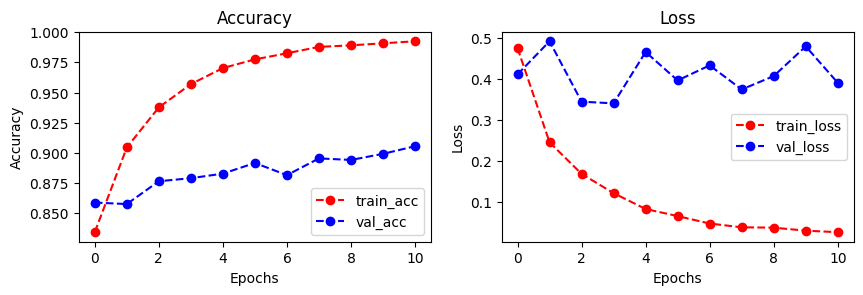

In [235]:
# Выводим графики после обучения модели
plot_accuracy_loss(history)

In [251]:
# Выводим метрики f1-score
pred = model.predict(test_batches)
y_pred_labels = np.argmax(pred, axis=1)

f1 = f1_score(y_true=test_batches.classes, y_pred=y_pred_labels, average='weighted')
print(f1)

report = classification_report(test_batches.classes, y_pred_labels)
print(report)

8/8 [==============================] - 7s 832ms/step
0.2312162888658668
              precision    recall  f1-score   support

           0       0.17      0.18      0.17        62
           1       0.21      0.21      0.21        61
           2       0.25      0.23      0.24        62
           3       0.30      0.31      0.30        62

    accuracy                           0.23       247
   macro avg       0.23      0.23      0.23       247
weighted avg       0.23      0.23      0.23       247


In [247]:
# Тестирование модели
scores = model.evaluate(test_batches)
print(f'Accuracy: {round((scores[1]*100), 2)}%')

8/8 [==============================] - 7s 855ms/step - loss: 0.3042 - accuracy: 0.9028
Accuracy: 90.28%


In [ ]:
# Сохраняем обученную модель в нужную нам директорию
model.save('../../test_model/model_test_final')